# **CS282br Final Project**
Varshini Reddy,
Michael Cheng,
Matthew Nazari

In [29]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

**Datasets**
1. Cost $\in 13226 \times 2$
2. Pneumonia $\in 5856 \times 13228$
3. Pneumonia base $\in 1171 \times 13228$

In [2]:
# Datasets
dfs = dict(
  cost=pd.read_csv('data/cost.csv'),
  pneumonia=pd.read_csv('data/pneumonia.csv', low_memory=False),
  pneumonia_base=pd.read_csv('data/pneumonia_base_train.csv'),
)

In [50]:
# Dataframe utilites

## split a dataframe into x_train and y_train for logistic regression
def datafy (x: pd.DataFrame, y: pd.DataFrame):
  return x.values, y.values.ravel()

def split_df(df: pd.DataFrame, ignore_cols: list[str] = ['cause'], ret_df: bool = True):
  kept_cols = df.columns != 'class'
  for c in ignore_cols:
    kept_cols &= (df.columns != c)
  x, y = df.loc[:, kept_cols], df.loc[:, df.columns == 'class']
  return (x, y) if ret_df else datafy(x, y)

def random_rows(x: np.ndarray, y: np.ndarray, p: float):
  assert 0 <= p <= 1, "random_rows: invalid percentage"
  assert x.shape[0] == y.shape[0], "random_rows: x.shape[0] != y.shape[0]"
  idxs = npr.choice(x.shape[0], int(x.shape[0]*p), replace=False)
  return x[idxs, :], y[idxs]

def logreg_score(x: np.ndarray, y: np.ndarray, p: float = 0.05):
  x_train, y_train = random_rows(x, y, p)
  lr = LogisticRegression().fit(x_train, y_train)
  return lr.score(x, y)

**Feature Selection Algorithms**
- All features
- Random drop 50%
- Random drop 75%
- CMAB-GFS [(epubs.siam.org/doi/pdf/10.1137/1.9781611976700.36)](https://epubs.siam.org/doi/pdf/10.1137/1.9781611976700.36)

In [51]:
# Feature Selection Algorithms

## All features
all_features = lambda df: split_df(df)[0].columns

## Random drop 50% and 75%
def random_drop(df: pd.DataFrame, p: float):
  assert 0 <= p <= 1, "random_drop: invalid percentage"
  x, _ = split_df(df)
  return npr.choice(x.columns, x.shape[0]*p)

random_drop_50 = lambda df: random_drop(df, 0.50)
random_drop_75 = lambda df: random_drop(df, 0.75)

## CMAB-GFS
def generative_oracle (M, K, betas, eps):
  if npr.rand() < eps:
    return npr.choice(M, K)
  else:
    samples = {c: npr.beta(*params) for c, params in betas.items()}
    return [k for k, _ in sorted(samples.items(), key=lambda item: item[1], reverse=True)][:K]

def cmab_gfs(df, K, T, eps):
  assert 0 <= eps <= 1, "cmab_gfs: eps must be in [0, 1]"
  x, y = split_df(df)
  M = x.columns
  R = lambda f: logreg_score(*datafy(x.loc[:, f], y))
  betas = {c: (0.5, 0.5) for c in M}
  S_old = npr.choice(M, K)
  r_old = R(S_old)
  history = []
  for _ in tqdm(range(T)):
    history.append(r_old)
    S_new = generative_oracle(M, K, betas, eps)
    r_new = R(S_new)
    for i in np.union1d(S_old, S_new):
      a, b = betas[i]
      betas[i] = (a+1, b) if r_new > r_old else (a, b+1)
    S_old, r_old = S_new, r_new
  # plt.plot(history)
  return S_new
    

100%|██████████| 1000/1000 [00:20<00:00, 48.64it/s]


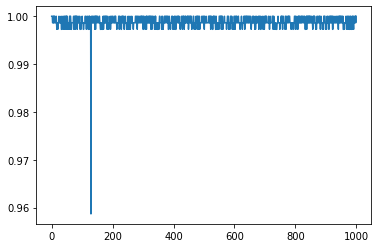

In [57]:
cmab_gfs(dfs['pneumonia'], K=100, T=1000, eps=0.25)